# Machine Learning KNN

[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 1.8935758495351205


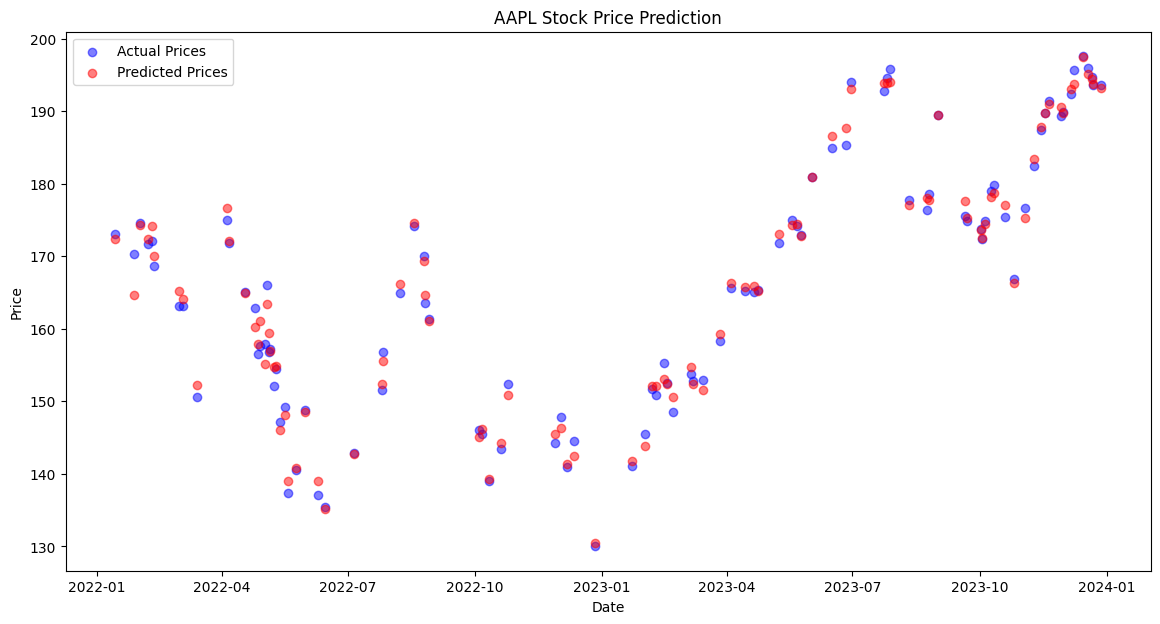

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Pour récupérer les données boursières
import yfinance as yf

# Télécharger les données historiques de l'action Apple
aapl = yf.download('AAPL', start='2022-01-01', end='2024-01-01')

# Calculer les rendements quotidiens
aapl['Return'] = aapl['Close'].pct_change()

# Créer d'autres caractéristiques potentielles
aapl['MA_5'] = aapl['Close'].rolling(window=5).mean()
aapl['MA_10'] = aapl['Close'].rolling(window=10).mean()

# Nettoyer les données en supprimant les valeurs NaN
aapl.dropna(inplace=True)

# Définir les caractéristiques (X) et la cible (y)
X = aapl[['Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_10']]
y = aapl['Close']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliser les caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer et entraîner le modèle de forêt aléatoire
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Faire des prévisions sur l'ensemble de test
y_pred = model.predict(X_test_scaled)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Tracer les prévisions par rapport aux vraies valeurs
plt.figure(figsize=(14, 7))
plt.scatter(y_test.index, y_test, color='blue', label='Actual Prices', alpha=0.5)
plt.scatter(y_test.index, y_pred, color='red', label='Predicted Prices', alpha=0.5)
plt.legend()
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



In [ ]:
import csv
import random
import math
import operator
import datetime
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go
import plotly.subplots as sp

# Function to split the data into a training dataset and test dataset in a ratio of 67/33
def loadDataset(filename, split, trainingSet=[], testSet=[], content_header=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset) - 1):
            for y in range(1, len(content_header) - 1):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])

def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(1, length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

def getNeighbors(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance) - 1
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return (correct / float(len(testSet))) * 100.0

def change(today, yest):
    if today > yest:
        return 'up'
    return 'down'

def getData(filename, stockname, startdate, enddate):
    stock = yf.download(stockname, start=startdate, end=enddate)
    print("Done making network call")

    first_time = True
    with open(filename, 'w', newline='') as pp:
        stockwriter = csv.writer(pp)
        for i in range(1, len(stock)):
            new_format_date = stock.index[i].strftime("%Y-%m-%d")
            if first_time:
                first_time = False
                prev_closing = stock['Adj Close'].iloc[i-1]
                continue
            stockwriter.writerow([new_format_date] + [stock['Open'].iloc[i]] + [stock['High'].iloc[i]] + [stock['Low'].iloc[i]] + [stock['Adj Close'].iloc[i]] + [change(stock['Adj Close'].iloc[i], prev_closing)])
            prev_closing = stock['Adj Close'].iloc[i]
    return stock  # Return the stock data for further use

def predictFor(k, filename, stockname, startdate, enddate, writeAgain, split):
    iv = ["date", "open", "high", "low", "yesterday closing adj", "state change"]
    trainingSet = []
    testSet = []
    totalCount = 0

    if writeAgain:
        print("Making a network request")
        stock = getData(filename, stockname, startdate, enddate)
    else:
        stock = None

    loadDataset(filename, split, trainingSet, testSet, iv)

    print("Predicting for ", stockname)
    print("Train: " + repr(len(trainingSet)))
    print("Test: " + repr(len(testSet)))
    totalCount += len(trainingSet) + len(testSet)
    print("Total: " + repr(totalCount))

    predict_and_get_accuracy(testSet, trainingSet, k, stockname, stock)

def predict_and_get_accuracy(testSet, trainingSet, k, stockname, stock):
    predictions = []
    price_predictions = []

    for x in range(len(testSet)):
        neighbors = getNeighbors(trainingSet, testSet[x], k)
        trend_result = getResponse(neighbors)
        predictions.append(trend_result)

        # Predict the price by averaging the neighbors' close prices
        price = sum(neighbor[4] for neighbor in neighbors) / len(neighbors)
        price_predictions.append(price)

    accuracy = getAccuracy(testSet, predictions)
    print('Accuracy: ' + repr(accuracy) + '%')

    dates = [datetime.datetime.strptime(testSet[dates][0], "%Y-%m-%d") for dates in range(len(testSet))]
    actual_trend = [1 if testSet[dates][-1] == "up" else -1 for dates in range(len(testSet))]
    predicted_trend = [1 if predictions[dates] == "up" else -1 for dates in range(len(testSet))]

    # Create subplots
    fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                           subplot_titles=("Stock movement of " + stockname,
                                           "Prediction vs Actual Trend of " + stockname,
                                           "Predicted vs Actual Prices"))

    # Add stock price trace
    fig.add_trace(go.Scatter(x=stock.index, y=stock["Adj Close"], mode='lines', name='Actual Stock Price', line=dict(color='blue', width=2)), row=1, col=1)

    # Add actual trend trace
    fig.add_trace(go.Scatter(x=dates, y=actual_trend, mode='lines+markers', name='Actual Trend', line=dict(color='blue', width=3)), row=2, col=1)

    # Add predicted trend trace
    fig.add_trace(go.Scatter(x=dates, y=predicted_trend, mode='lines+markers', name='Predicted Trend', line=dict(color='red', dash='dash', width=3)), row=2, col=1)

    # Add actual vs predicted prices
    fig.add_trace(go.Scatter(x=dates, y=[testSet[dates][4] for dates in range(len(testSet))], mode='lines+markers', name='Actual Prices', line=dict(color='blue', width=2)), row=3, col=1)
    fig.add_trace(go.Scatter(x=dates, y=price_predictions, mode='lines+markers', name='Predicted Prices', line=dict(color='red', dash='dash', width=2)), row=3, col=1)

    # Update layout
    fig.update_layout(height=1300, width=1700, title_text=f"Stock Prediction Analysis for {stockname}", showlegend=True)
    fig.update_yaxes(title_text="Adjusted Close Price", row=1, col=1)
    fig.update_yaxes(title_text="Trend", row=2, col=1)
    fig.update_yaxes(title_text="Price", row=3, col=1)
    fig.update_xaxes(title_text="Date", row=3, col=1)

    # Show plot
    fig.show()

def main():
    split = 0.67
    startdate = datetime.datetime(2022, 1, 1)
    enddate = datetime.date.today()

    # Predicting for Apple Inc. (AAPL)
    predictFor(5, 'aapl.csv', 'AAPL', startdate, enddate, True, split)

main()


[*********************100%%**********************]  1 of 1 completed

Making a network request
Done making network call


Predicting for  AAPL
Train: 441
Test: 220
Total: 661
Accuracy: 70.45454545454545%


# Outliers detection using KNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import yfinance as yf
import plotly.graph_objects as go

# Fetch LVMH stock data using yfinance
lvmh_ticker = 'MC.PA'  # LVMH ticker on Euronext Paris
start_date = '2022-01-01'
end_date = '2023-12-31'
lvmh_data = yf.download(lvmh_ticker, start=start_date, end=end_date)

# Use 'Adj Close' for adjusted closing prices
data = pd.DataFrame(data={'Date': lvmh_data.index, 'Close': lvmh_data['Adj Close']})

# Preprocess the data
scaler = StandardScaler()
data['Scaled'] = scaler.fit_transform(data[['Close']])
X = data['Scaled'].values.reshape(-1, 1)

# Train a KNN model
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X)

# Calculate distances to the K nearest neighbors
distances, _ = knn.kneighbors(X)

# Identify outliers based on a threshold
outlier_threshold = np.mean(distances) + 2 * np.std(distances)
outliers = distances.mean(axis=1) > outlier_threshold

# Convert Date index to string for Plotly
data['DateString'] = data['Date'].dt.strftime('%Y-%m-%d')

# Create a trace for the actual prices
trace_actual = go.Scatter(x=data['DateString'], y=data['Close'], mode='lines', name='Actual Prices')

# Create a trace for the outliers
outlier_indices = np.where(outliers)[0]
trace_outliers = go.Scatter(x=data['DateString'].iloc[outlier_indices], y=data['Close'].iloc[outlier_indices], mode='markers', name='Outliers', marker=dict(color='red', size=10))

# Layout for the plot
layout = go.Layout(title='LVMH Price Outliers Detection using KNN',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price'),
                   hovermode='closest')

# Create the figure and add traces
fig = go.Figure(data=[trace_actual, trace_outliers], layout=layout)

# Show the figure
fig.show()

# Print the number of outliers
num_outliers = np.sum(outliers)
print("Number of outliers:", num_outliers)

# Print the outliers and their corresponding date and price
outlier_dates = data['Date'].iloc[outlier_indices]
outlier_prices = data['Close'].iloc[outlier_indices]

print("Outliers:")
for date, price in zip(outlier_dates, outlier_prices):
    print("Date:", date, "| Price:", price)


[*********************100%***********************]  1 of 1 completed


Number of outliers: 7
Outliers:
Date: 2022-05-20 00:00:00 | Price: 539.0977783203125
Date: 2022-06-16 00:00:00 | Price: 522.4386596679688
Date: 2023-01-11 00:00:00 | Price: 753.1224365234375
Date: 2023-04-24 00:00:00 | Price: 879.6017456054688
Date: 2023-06-30 00:00:00 | Price: 848.15234375
Date: 2023-09-05 00:00:00 | Price: 746.0398559570312
Date: 2023-09-15 00:00:00 | Price: 748.103759765625


# Volatility prediction with KNN

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-1-d5999de13630>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10

Mean Squared Error for Volatility Prediction: 1.1272615160299601e-06


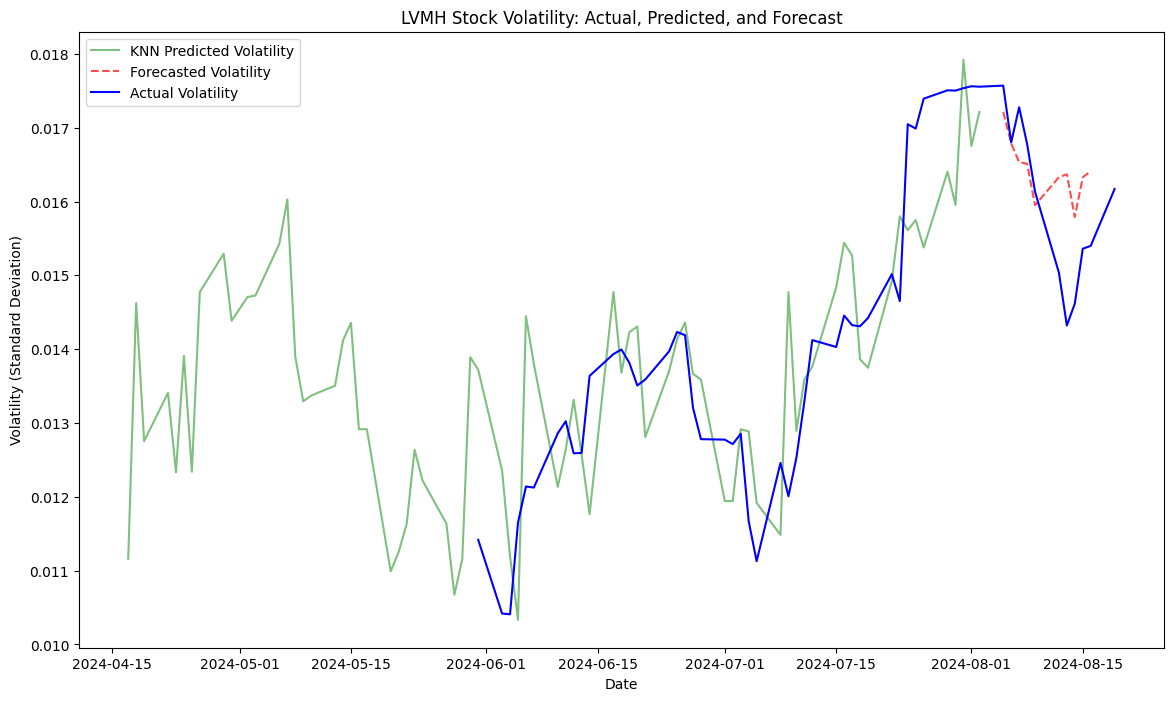

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Data Acquisition - Download historical data for LVMH
end_date = '2024-08-05'
stock_data = yf.download('MC.PA', start='2023-01-01', end=end_date)

# Download additional data for 10 days after the initial end date
additional_data = yf.download('MC.PA', start=pd.to_datetime(end_date) + pd.Timedelta(days=1), end=pd.to_datetime(end_date) + pd.Timedelta(days=10))

# Step 2: Feature Engineering
# Calculate daily returns
stock_data['Return'] = stock_data['Adj Close'].pct_change()
additional_data['Return'] = additional_data['Adj Close'].pct_change()

# Calculate rolling volatility (standard deviation of returns over a window)
stock_data['Volatility'] = stock_data['Return'].rolling(window=21).std()  # 21-day rolling volatility
additional_data['Volatility'] = additional_data['Return'].rolling(window=21).std()

# Drop NaN values
stock_data.dropna(inplace=True)
additional_data.dropna(inplace=True)

# Step 3: Feature Selection
# We use lagged returns and volatility as features
stock_data['Lagged_Volatility'] = stock_data['Volatility'].shift(1)
stock_data['Lagged_Return'] = stock_data['Return'].shift(1)
additional_data['Lagged_Volatility'] = additional_data['Volatility'].shift(1)
additional_data['Lagged_Return'] = additional_data['Return'].shift(1)

# Prepare the features and target for modeling
X = stock_data[['Lagged_Volatility', 'Lagged_Return']]
y = stock_data['Volatility']

# Drop NaN values that result from shifting
X.dropna(inplace=True)
y = y.loc[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Model Training using KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Step 5: Volatility Prediction and Evaluation
y_pred = knn_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for Volatility Prediction: {mse}')

# Step 6: Forecasting Future Volatility
forecast_horizon = 10  # Number of days to forecast
forecasted_volatility = []
forecast_dates = pd.date_range(start=X_test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

last_X = X_test.iloc[-1, :].values.reshape(1, -1)  # Take the last row from X_test

for _ in range(forecast_horizon):
    # Predict the next volatility
    next_volatility = knn_model.predict(last_X)
    forecasted_volatility.append(next_volatility[0])

    # Update last_X with the predicted volatility and simulate a small random return
    new_lagged_volatility = next_volatility[0]
    new_lagged_return = np.random.normal(0, np.std(X_test['Lagged_Return']))  # Simulate return with noise
    last_X = np.array([[new_lagged_volatility, new_lagged_return]])

# Convert forecasted data to DataFrame for easy plotting
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Volatility': forecasted_volatility
})

# True data plot steps
end_date_true_plot = '2024-08-20'
stock_data_true = yf.download('MC.PA', start='2024-05-01', end=end_date_true_plot)
stock_data_true['Return'] = stock_data_true['Adj Close'].pct_change()
stock_data_true['Volatility'] = stock_data_true['Return'].rolling(window=21).std()
stock_data_true.dropna(inplace=True)

# Step 7: Plotting All Volatilities Together
plt.figure(figsize=(14, 8))

# Plot predicted volatility
plt.plot(y_test.index, y_pred, color='green', label='KNN Predicted Volatility', alpha=0.5)

# Plot forecasted volatility
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Volatility'], color='red', label='Forecasted Volatility', alpha=0.7, linestyle='--')

# Plot actual volatility
plt.plot(stock_data_true.index, stock_data_true['Volatility'], color='blue', label='Actual Volatility')

plt.title('LVMH Stock Volatility: Actual, Predicted, and Forecast')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.show()


# DBSCAN

[*********************100%***********************]  1 of 1 completed


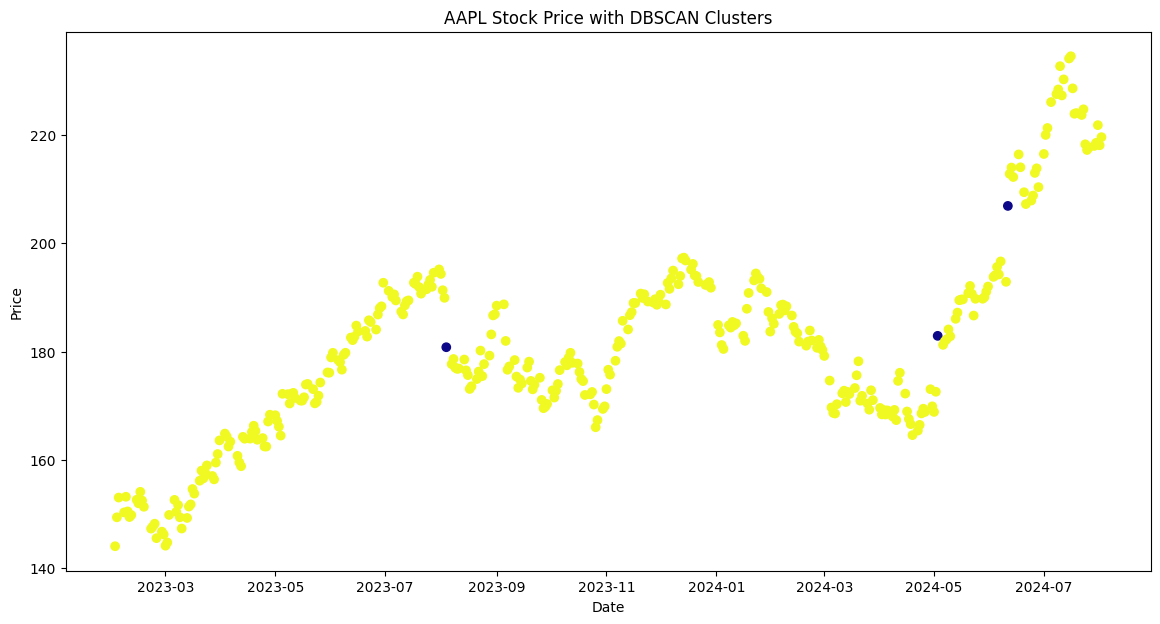

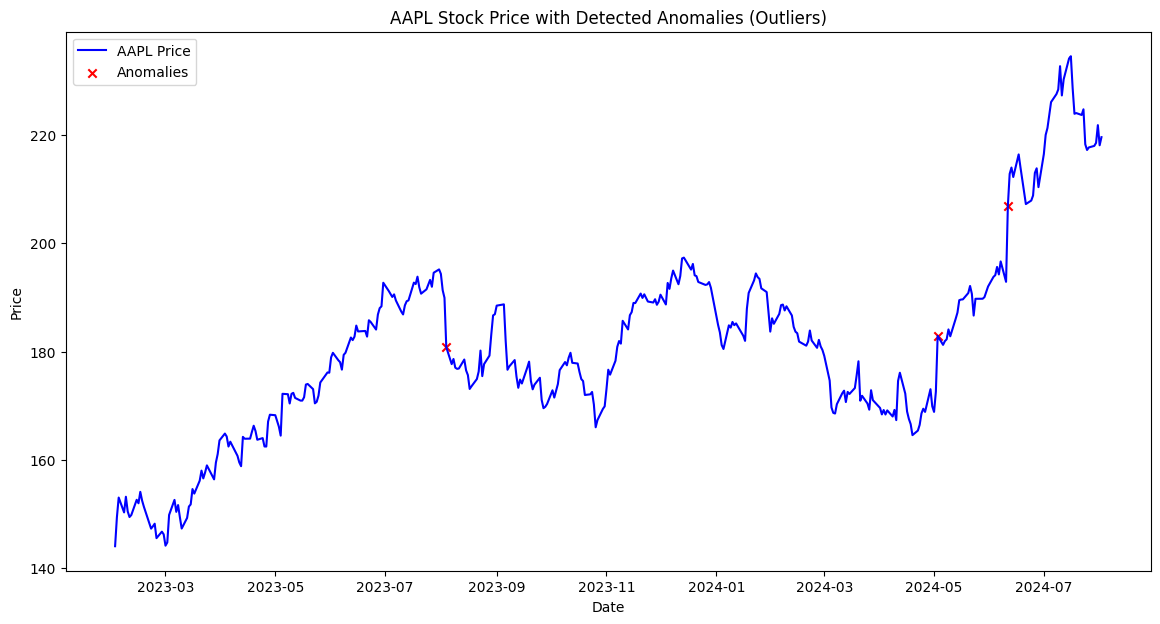

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Step 1: Download historical stock price data
stock_data = yf.download('AAPL', start='2023-01-01', end='2024-08-05')

# Step 2: Calculate daily returns
stock_data['Return'] = stock_data['Adj Close'].pct_change()

# Step 3: Prepare the feature set (using returns and rolling volatility as features)
stock_data['Volatility'] = stock_data['Return'].rolling(window=20).std()
stock_data.dropna(inplace=True)  # Drop NaN values

X = stock_data[['Return', 'Volatility']]

# Step 4: Apply DBSCAN for anomaly detection
dbscan = DBSCAN(eps=0.01, min_samples=5)
clusters = dbscan.fit_predict(X)

# Step 5: Add cluster labels to the dataframe
stock_data['Cluster'] = clusters

# Step 6: Visualize the results
plt.figure(figsize=(14, 7))
plt.scatter(stock_data.index, stock_data['Adj Close'], c=stock_data['Cluster'], cmap='plasma', label='DBSCAN Clusters')
plt.title('AAPL Stock Price with DBSCAN Clusters')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Step 7: Highlight potential anomalies (outliers are labeled as -1 by DBSCAN)
anomalies = stock_data[stock_data['Cluster'] == -1]
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Adj Close'], label='AAPL Price', color='blue')
plt.scatter(anomalies.index, anomalies['Adj Close'], color='red', label='Anomalies', marker='x')
plt.title('AAPL Stock Price with Detected Anomalies (Outliers)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# DBSCAN Clusters

[*********************100%***********************]  1 of 1 completed


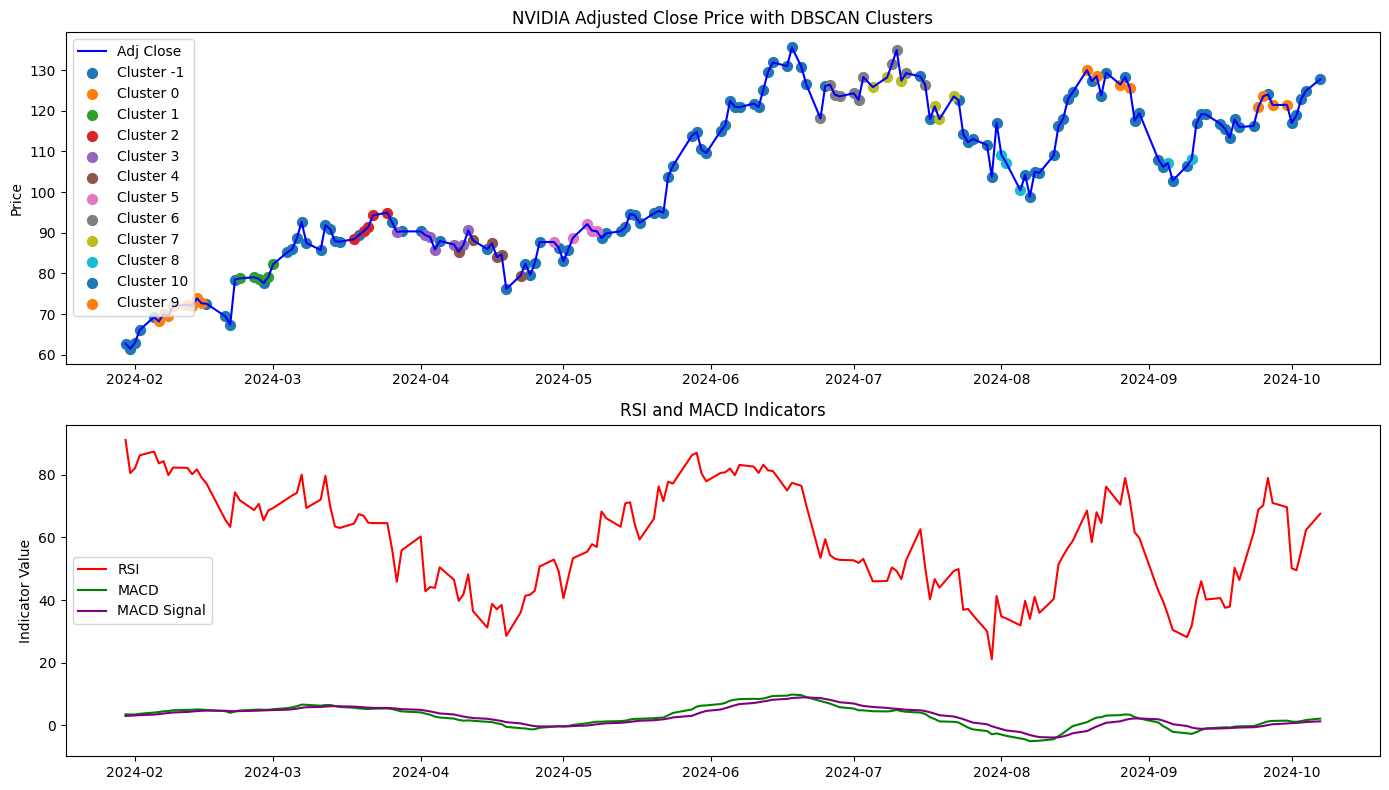

In [ ]:
import yfinance as yf
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download historical data for NVIDIA from 2024-01-02 to today
nvidia_data = yf.download('NVDA', start='2024-01-02', end='2024-10-08')

# Calculate technical indicators: RSI, MACD, and Moving Averages
def calculate_rsi(data, window=14):
    delta = data['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Adj Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Adj Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_moving_average(data, window=20):
    return data['Adj Close'].rolling(window=window).mean()

# Calculate RSI, MACD and 20-day moving average
nvidia_data['RSI'] = calculate_rsi(nvidia_data)
nvidia_data['MACD'], nvidia_data['MACD_Signal'] = calculate_macd(nvidia_data)
nvidia_data['SMA'] = calculate_moving_average(nvidia_data)

# Drop rows with NaN values due to rolling windows
nvidia_data.dropna(inplace=True)

# Prepare features for DBSCAN: RSI, MACD, and Moving Averages
features = nvidia_data[['RSI', 'MACD', 'SMA']].values

# Apply DBSCAN to cluster the technical indicators
dbscan = DBSCAN(eps=3, min_samples=5)
nvidia_data['Cluster'] = dbscan.fit_predict(features)

# Plot the results
plt.figure(figsize=(14, 8))

# Plot Adjusted Close price with clusters
plt.subplot(2, 1, 1)
plt.plot(nvidia_data.index, nvidia_data['Adj Close'], label='Adj Close', color='blue')
plt.title('NVIDIA Adjusted Close Price with DBSCAN Clusters')
plt.ylabel('Price')
for cluster in nvidia_data['Cluster'].unique():
    cluster_indices = nvidia_data[nvidia_data['Cluster'] == cluster].index
    plt.scatter(cluster_indices, nvidia_data.loc[cluster_indices, 'Adj Close'], label=f'Cluster {cluster}', s=50)
plt.legend()

# Plot RSI and MACD
plt.subplot(2, 1, 2)
plt.plot(nvidia_data.index, nvidia_data['RSI'], label='RSI', color='red')
plt.plot(nvidia_data.index, nvidia_data['MACD'], label='MACD', color='green')
plt.plot(nvidia_data.index, nvidia_data['MACD_Signal'], label='MACD Signal', color='purple')
plt.title('RSI and MACD Indicators')
plt.ylabel('Indicator Value')
plt.legend()

plt.tight_layout()
plt.show()


# DBSCAN - price clustering

In [ ]:
import yfinance as yf
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Download historical data for NVIDIA from 2024-01-02 to today
nvidia_data = yf.download('NVDA', start='2024-01-02', end='2024-10-08')

# Calculate technical indicators: RSI, MACD, and Moving Averages
def calculate_rsi(data, window=14):
    delta = data['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Adj Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Adj Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_moving_average(data, window=20):
    return data['Adj Close'].rolling(window=window).mean()

# Calculate RSI, MACD and 20-day moving average
nvidia_data['RSI'] = calculate_rsi(nvidia_data)
nvidia_data['MACD'], nvidia_data['MACD_Signal'] = calculate_macd(nvidia_data)
nvidia_data['SMA'] = calculate_moving_average(nvidia_data)

# Drop rows with NaN values due to rolling windows
nvidia_data.dropna(inplace=True)

# Prepare features for DBSCAN: RSI, MACD, and Moving Averages
features = nvidia_data[['RSI', 'MACD', 'SMA']].values

# Apply DBSCAN to cluster the technical indicators
dbscan = DBSCAN(eps=3, min_samples=5)
nvidia_data['Cluster'] = dbscan.fit_predict(features)

# Define buy and sell conditions based on the user's strategy
nvidia_data['Trend'] = nvidia_data['Adj Close'].diff().fillna(0)
nvidia_data['Buy_Signal'] = np.nan
nvidia_data['Sell_Signal'] = np.nan


# Iterate over the dataset to check for 3 consecutive points in the same cluster
for i in range(4, len(nvidia_data)):
    # Check if 3 consecutive points are in the same cluster
    if (nvidia_data['Cluster'].iloc[i] == nvidia_data['Cluster'].iloc[i-1] == nvidia_data['Cluster'].iloc[i-2] == nvidia_data['Cluster'].iloc[i-3]== nvidia_data['Cluster'].iloc[i-4]):
        # Check if the trend is upward (prices increasing)
        if (nvidia_data['Adj Close'].iloc[i] > nvidia_data['Adj Close'].iloc[i-4]):
            nvidia_data['Buy_Signal'].iloc[i] = nvidia_data['Adj Close'].iloc[i]
        # Check if the trend is downward (prices decreasing)
        elif (nvidia_data['Adj Close'].iloc[i] < nvidia_data['Adj Close'].iloc[i-4]):
            nvidia_data['Sell_Signal'].iloc[i] = nvidia_data['Adj Close'].iloc[i]

# Create a Plotly figure with subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1, subplot_titles=('NVIDIA Adjusted Close with Buy/Sell Signals and Clusters', 'RSI and MACD Indicators'))

# Plot Adjusted Close Price
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['Adj Close'], mode='lines', name='Adj Close', line=dict(color='blue')), row=1, col=1)

# Plot Buy and Sell Signals
# fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['Buy_Signal'], mode='markers', name='Buy Signal', marker=dict(color='green', symbol='triangle-up', size=10)), row=1, col=1)
# fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['Sell_Signal'], mode='markers', name='Sell Signal', marker=dict(color='red', symbol='triangle-down', size=10)), row=1, col=1)

# Plot the DBSCAN Clusters (with different colors for each cluster)
for cluster in nvidia_data['Cluster'].unique():
    cluster_data = nvidia_data[nvidia_data['Cluster'] == cluster]
    fig.add_trace(go.Scatter(x=cluster_data.index, y=cluster_data['Adj Close'], mode='markers', name=f'Cluster {cluster}'), row=1, col=1)

# Plot RSI
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['RSI'], mode='lines', name='RSI', line=dict(color='red')), row=2, col=1)

# Plot MACD and Signal Line
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['MACD'], mode='lines', name='MACD', line=dict(color='green')), row=2, col=1)
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['MACD_Signal'], mode='lines', name='MACD Signal', line=dict(color='purple')), row=2, col=1)

# Update layout to improve aesthetics
fig.update_layout(height=800, width=1200, title_text='Interactive NVIDIA Trading Strategy with DBSCAN Clusters, Buy/Sell Signals', xaxis_rangeslider_visible=False)

# Show the plot
fig.show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-17-8a0852c8e51d>:61: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-17-8a0852c8e51d>:61: SettingWithCopyWarning:


A value is trying to be set 

# DBSCAN - Momentum trading

In [ ]:
import yfinance as yf
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Download historical data for NVIDIA from 2024-01-02 to today
nvidia_data = yf.download('NVDA', start='2024-01-02', end='2024-10-08')

# Calculate technical indicators: RSI, MACD, and Moving Averages
def calculate_rsi(data, window=14):
    delta = data['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Adj Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Adj Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_moving_average(data, window=20):
    return data['Adj Close'].rolling(window=window).mean()

# Calculate RSI, MACD and 20-day moving average
nvidia_data['RSI'] = calculate_rsi(nvidia_data)
nvidia_data['MACD'], nvidia_data['MACD_Signal'] = calculate_macd(nvidia_data)
nvidia_data['SMA'] = calculate_moving_average(nvidia_data)

# Drop rows with NaN values due to rolling windows
nvidia_data.dropna(inplace=True)

# Prepare features for DBSCAN: RSI, MACD, and Moving Averages
features = nvidia_data[['RSI', 'MACD', 'SMA']].values

# Apply DBSCAN to cluster the technical indicators
dbscan = DBSCAN(eps=3, min_samples=5)
nvidia_data['Cluster'] = dbscan.fit_predict(features)

# Define buy and sell conditions based on the user's strategy
nvidia_data['Trend'] = nvidia_data['Adj Close'].diff().fillna(0)
nvidia_data['Buy_Signal'] = np.nan
nvidia_data['Sell_Signal'] = np.nan


# Iterate over the dataset to check for 3 consecutive points in the same cluster
for i in range(4, len(nvidia_data)):
    # Check if 3 consecutive points are in the same cluster
    if (nvidia_data['Cluster'].iloc[i] == nvidia_data['Cluster'].iloc[i-1] == nvidia_data['Cluster'].iloc[i-2] == nvidia_data['Cluster'].iloc[i-3]== nvidia_data['Cluster'].iloc[i-4]):
        # Check if the trend is upward (prices increasing)
        if (nvidia_data['Adj Close'].iloc[i] > nvidia_data['Adj Close'].iloc[i-4]):
            nvidia_data['Buy_Signal'].iloc[i] = nvidia_data['Adj Close'].iloc[i]
        # Check if the trend is downward (prices decreasing)
        elif (nvidia_data['Adj Close'].iloc[i] < nvidia_data['Adj Close'].iloc[i-4]):
            nvidia_data['Sell_Signal'].iloc[i] = nvidia_data['Adj Close'].iloc[i]

# Create a Plotly figure with subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1, subplot_titles=('NVIDIA Adjusted Close with Buy/Sell Signals and Clusters', 'RSI and MACD Indicators'))

# Plot Adjusted Close Price
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['Adj Close'], mode='lines', name='Adj Close', line=dict(color='blue')), row=1, col=1)

# Plot Buy and Sell Signals
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['Buy_Signal'], mode='markers', name='Buy Signal', marker=dict(color='green', symbol='triangle-up', size=10)), row=1, col=1)
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['Sell_Signal'], mode='markers', name='Sell Signal', marker=dict(color='red', symbol='triangle-down', size=10)), row=1, col=1)

# Plot the DBSCAN Clusters (with different colors for each cluster)
for cluster in nvidia_data['Cluster'].unique():
    cluster_data = nvidia_data[nvidia_data['Cluster'] == cluster]
    # fig.add_trace(go.Scatter(x=cluster_data.index, y=cluster_data['Adj Close'], mode='markers', name=f'Cluster {cluster}'), row=1, col=1)

# Plot RSI
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['RSI'], mode='lines', name='RSI', line=dict(color='red')), row=2, col=1)

# Plot MACD and Signal Line
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['MACD'], mode='lines', name='MACD', line=dict(color='green')), row=2, col=1)
fig.add_trace(go.Scatter(x=nvidia_data.index, y=nvidia_data['MACD_Signal'], mode='lines', name='MACD Signal', line=dict(color='purple')), row=2, col=1)

# Update layout to improve aesthetics
fig.update_layout(height=800, width=1200, title_text='Interactive NVIDIA Trading Strategy with DBSCAN Clusters, Buy/Sell Signals', xaxis_rangeslider_visible=False)

# Show the plot
fig.show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-14-e8f599028fb5>:61: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-14-e8f599028fb5>:61: SettingWithCopyWarning:


A value is trying to be set 

# DBSCAN - stocks clustering and pair choosing

[*********************100%***********************]  40 of 40 completed


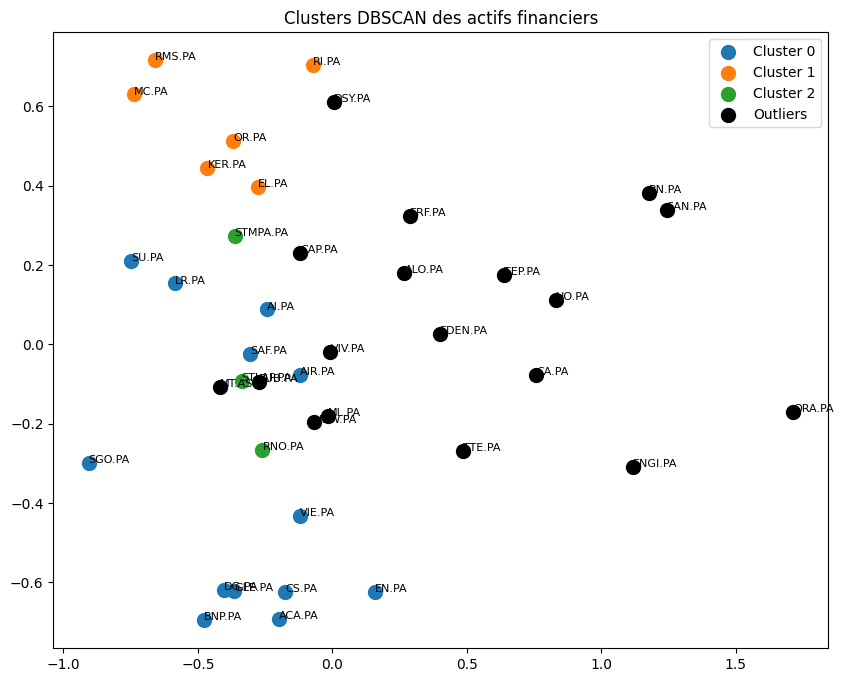

Clusters trouvés avec DBSCAN :
      Ticker  Cluster
0     ACA.PA        0
31    SGO.PA        0
29    SAF.PA        0
34     SU.PA        0
16    GLE.PA        0
13     EN.PA        0
19     LR.PA        0
9      DG.PA        0
8      CS.PA        0
5     BNP.PA        0
2     AIR.PA        0
1      AI.PA        0
38    VIE.PA        0
18    KER.PA        1
20     MC.PA        1
23     OR.PA        1
26     RI.PA        1
27    RMS.PA        1
12     EL.PA        1
28    RNO.PA        2
32  STLAP.PA        2
33  STMPA.PA        2


In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

list_ticker = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "CS.PA", "BNP.PA", "EN.PA", "CAP.PA", "CA.PA", "ACA.PA",
    "BN.PA", "DSY.PA", "EDEN.PA", "ENGI.PA", "EL.PA", "ERF.PA", "RMS.PA", "KER.PA", "LR.PA", "OR.PA",
    "MC.PA", "ML.PA", "ORA.PA", "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA", "URW.PA", "VIE.PA", "DG.PA", "VIV.PA"
]
def download_data(tickers):
    data = yf.download(tickers, start='2023-01-01', end='2024-10-10')['Adj Close']
    return data

def calculate_daily_returns(data):
    returns = data.pct_change().dropna()
    return returns

data = download_data(list_ticker)

returns = calculate_daily_returns(data)

correlation_matrix = returns.corr()

def apply_dbscan(correlation_matrix, eps=0.5, min_samples=2):
    distance_matrix = 1 - correlation_matrix
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = dbscan.fit_predict(distance_matrix)
    return labels

labels = apply_dbscan(correlation_matrix)

clustered_pairs = pd.DataFrame({
    'Ticker': correlation_matrix.columns,
    'Cluster': labels
})

pca = PCA(n_components=2)
pca_result = pca.fit_transform(1 - correlation_matrix)

plt.figure(figsize=(10, 8))
plt.title('Clusters DBSCAN des actifs financiers')

unique_clusters = np.unique(labels)
for cluster in unique_clusters:
    if cluster != -1:
        indices = np.where(labels == cluster)
        plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Cluster {cluster}', s=100)

outliers = np.where(labels == -1)
plt.scatter(pca_result[outliers, 0], pca_result[outliers, 1], label='Outliers', color='black', s=100)

for i, ticker in enumerate(correlation_matrix.columns):
    plt.annotate(ticker, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)

plt.legend()
plt.show()

print("Clusters trouvés avec DBSCAN :")
print(clustered_pairs[clustered_pairs['Cluster'] != -1].sort_values('Cluster'))


# Random Forest - Technical Analysis

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import plotly.graph_objs as go
from plotly.subplots import make_subplots

ticker = 'NVDA'
data = yf.download(ticker, start='2023-01-01', end='2024-10-10')

data['Returns'] = data['Adj Close'].pct_change()


data['SMA_20'] = data['Adj Close'].rolling(window=20).mean()
data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()


data['RSI'] = 100 - (100 / (1 + data['Returns'].rolling(window=14).mean()))


short_ema = data['Adj Close'].ewm(span=12, adjust=False).mean()
long_ema = data['Adj Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = short_ema - long_ema
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()


data['20_SMA'] = data['Adj Close'].rolling(window=20).mean()
data['20_std'] = data['Adj Close'].rolling(window=20).std()
data['Bollinger_Upper'] = data['20_SMA'] + (data['20_std'] * 2)
data['Bollinger_Lower'] = data['20_SMA'] - (data['20_std'] * 2)


data['Target'] = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)


data.dropna(inplace=True)


X = data[['SMA_20', 'SMA_50', 'RSI', 'Returns', 'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Lower']]
y = data['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


data['Predictions'] = np.nan
data.loc[X_test.index, 'Predictions'] = y_pred


fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1, subplot_titles=('AAPL Price and Predictions', 'RSI', 'MACD'))


fig.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], mode='lines', name='Adj Close', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Upper'], mode='lines', name='Upper Band', line=dict(color='orange', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Lower'], mode='lines', name='Lower Band', line=dict(color='orange', dash='dash')), row=1, col=1)


fig.add_trace(go.Scatter(x=data[data['Predictions'] == 1].index,
                         y=data['Adj Close'][data['Predictions'] == 1],
                         mode='markers', name='Buy Signal',
                         marker=dict(color='green', symbol='triangle-up', size=10)), row=1, col=1)

fig.add_trace(go.Scatter(x=data[data['Predictions'] == 0].index,
                         y=data['Adj Close'][data['Predictions'] == 0],
                         mode='markers', name='Sell Signal',
                         marker=dict(color='red', symbol='triangle-down', size=10)), row=1, col=1)


fig.add_trace(go.Scatter(x=data.index, y=data['RSI'], mode='lines', name='RSI', line=dict(color='purple')), row=2, col=1)


fig.add_trace(go.Scatter(x=data.index, y=data['MACD'], mode='lines', name='MACD', line=dict(color='green')), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['MACD_Signal'], mode='lines', name='MACD Signal', line=dict(color='red')), row=3, col=1)


fig.update_layout(height=900, width=1200, title_text='AAPL Stock Price and Trading Signals with MACD, Bollinger Bands', xaxis_rangeslider_visible=False)


fig.show()


[*********************100%***********************]  1 of 1 completed


# Random Forest - Stock choosing

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

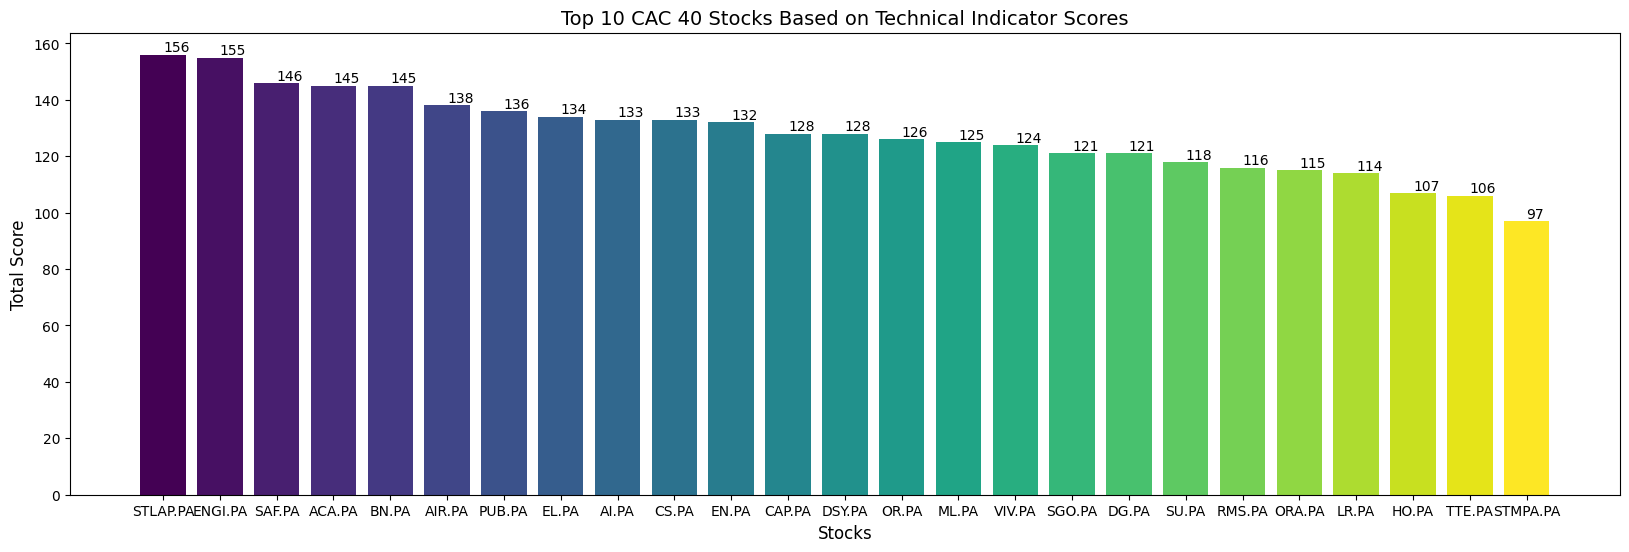

In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cac40_stocks = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "CS.PA", "BNP.PA", "EN.PA", "CAP.PA", "CA.PA", "ACA.PA",
    "BN.PA", "DSY.PA", "EDEN.PA", "ENGI.PA", "EL.PA", "ERF.PA", "RMS.PA", "KER.PA", "LR.PA", "OR.PA",
    "MC.PA", "ML.PA", "ORA.PA", "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA", "URW.PA", "VIE.PA", "DG.PA", "VIV.PA"
]

def download_data(stocks):
    stock_data = {}
    for stock in stocks:
        data = yf.download(stock, start="2023-01-01", end="2024-01-01")
        stock_data[stock] = data
    return stock_data

def calculate_technical_indicators(df):
    df['Returns'] = df['Adj Close'].pct_change()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Adj Close'].rolling(window=200).mean()
    df['RSI'] = 100 - (100 / (1 + df['Returns'].rolling(window=14).mean()))

    # MACD (EMA 12 et EMA 26 avec Signal Line EMA 9)
    df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['20_SMA'] = df['Adj Close'].rolling(window=20).mean()
    df['20_std'] = df['Adj Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = df['20_SMA'] + (df['20_std'] * 2)
    df['Bollinger_Lower'] = df['20_SMA'] - (df['20_std'] * 2)

    df.dropna(inplace=True)
    return df

stock_data = download_data(cac40_stocks)

for stock in cac40_stocks:
    stock_data[stock] = calculate_technical_indicators(stock_data[stock])

def calculate_score(df):
    score = {
        'SMA_Score': 0,
        'RSI_Score': 0,
        'MACD_Score': 0,
        'Bollinger_Score': 0,
        'Total_Score': 0
    }

    score['SMA_Score'] += np.where(df['Adj Close'] > df['SMA_50'], 1, 0).sum()
    score['SMA_Score'] += np.where(df['Adj Close'] > df['SMA_200'], 1, 0).sum()

    score['RSI_Score'] += np.where((df['RSI'] > 30) & (df['RSI'] < 70), 1, 0).sum()

    score['MACD_Score'] += np.where(df['MACD'] > df['MACD_Signal'], 1, 0).sum()

    score['Bollinger_Score'] += np.where(df['Adj Close'] > df['Bollinger_Upper'], 1, 0).sum()

    score['Total_Score'] = score['SMA_Score'] + score['RSI_Score'] + score['MACD_Score'] + score['Bollinger_Score']

    return score

stock_scores = {}
for stock in cac40_stocks:
    score = calculate_score(stock_data[stock])
    stock_scores[stock] = score

top_stocks = sorted(stock_scores.items(), key=lambda x: x[1]['Total_Score'], reverse=True)[:25]

stocks = [stock[0] for stock in top_stocks]
scores = [stock[1]['Total_Score'] for stock in top_stocks]

plt.figure(figsize=(20, 6))
bars = plt.bar(stocks, scores, color=plt.cm.viridis(np.linspace(0, 1, len(stocks))))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.title('Top 10 CAC 40 Stocks Based on Technical Indicator Scores', fontsize=14)
plt.xlabel('Stocks', fontsize=12)
plt.ylabel('Total Score', fontsize=12)

plt.show()
